In [1]:
# ===== 1. IMPORTS OCH INL√ÑSNING =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix


# ===== GLOBAL PROJEKTDATA =====
# Syfte: En central dictionary f√∂r att lagra projektets data och parametrar
# Alternativ: Globala variabler, konfigurationsfil, eller klasstruktur
# Varf√∂r: Dictionary ger flexibel struktur och enkel √•tkomst till data

# ----- Datalagring -----
# Vad: Tom dictionary som fylls under projektets g√•ng
# Varf√∂r: M√∂jligg√∂r dynamisk lagring av data mellan olika analysdelar
# Parametrar: Kommer inneh√•lla nyckel-v√§rde par f√∂r viktiga projektvariabler
PROJECT_DATA = {}

# ===== DATAINL√ÑSNING =====


# ----- Inl√§sning -----
# L√§ser in data fr√•n CSV-fil till pandas DataFrame
df = pd.read_csv('project_data.csv')

# ----- Arbetskopia -----
# Vad: Skapar en kopia av data f√∂r s√§ker bearbetning
# Varf√∂r: Undviker att modifiera originaldata av misstag
# Parametrar: Ingen parametermodifiering, ren kopia
df_clean = df.copy()

# Ta bort on√∂dig indexkolumn
df_clean = df_clean.drop('Unnamed: 0', axis=1)

# ===== 2. INITIAL DATAINSPEKTION =====
# Syfte: Unders√∂ka datasetets grundl√§ggande egenskaper och kvalitet
# Alternativ: Mer detaljerad EDA, visualiseringar, beskrivande statistik
# Varf√∂r: Snabb √∂verblick f√∂r att identifiera omfattning och datakvalitetsproblem

# ----- Dimensioner -----
# Vad: Visar antal rader och kolumner i datasetet
# Varf√∂r: Ger snabb √∂verblick av datasetets storlek
print("Initial datainspektion:")
print(f"Datasetets dimensioner: {df_clean.shape}")

# ----- Saknade v√§rden -----
# Vad: Identifierar kolumner med saknade v√§rden
# Varf√∂r: Kritiskt att k√§nna till f√∂r vidare databehandling
# Parametrar: Visar endast kolumner d√§r antalet saknade v√§rden > 0
print("\nSaknade v√§rden per kolumn:")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# ===== 3. HANTERA SAKNADE V√ÑRDEN =====
# Syfte: Ta bort rader med saknade v√§rden i Revenue-kolumnen f√∂rst
# Alternativ: Imputering av saknade v√§rden eller beh√•lla rader med saknade v√§rden
# Varf√∂r: Revenue √§r m√•lvariabeln och kan inte imputeras meningsfullt

# ----- Revenue-rensning -----
# Vad: Tar bort rader d√§r Revenue saknas
# Varf√∂r: M√•lvariabeln m√•ste finnas f√∂r tr√§ning/utv√§rdering
# Parametrar: dropna() med subset=['Revenue'] tar endast bort rader d√§r Revenue saknas
print("\nHantering av saknade v√§rden:")
print(f"Rader f√∂re Revenue-rensning: {len(df_clean)}")
df_clean = df_clean.dropna(subset=['Revenue'])
print(f"Rader efter Revenue-rensning: {len(df_clean)}")

# ===== Data Cleaning: Weekend Column =====
# Syfte: Hantera felaktiga ('Name:Zara') och saknade v√§rden (np.nan) i Weekend-kolumnen
# 
# RESONEMANG F√ñR VALD L√ñSNING:
# 1. Databevarande:
#    - Vill beh√•lla s√• mycket data som m√∂jligt 
#    - Att ta bort rader med saknade v√§rden skulle riskera bias
#
# 2. 'Missing' som informativ feature:
#    - Saknad Weekend-data kan vara ett m√∂nster i sig
#    - Modellen kan l√§ra sig fr√•n sessioner med 'Missing'
#    - Mer informativt √§n att gissa/imputera v√§rden
#
# 3. Alternativ som √∂verv√§gdes:
#    - Imputation med mode/median (f√∂rkastat: skulle skapa bias)
#    - Radera rader (f√∂rkastat: f√∂r stor dataf√∂rlust)
#    - Separata kategorier f√∂r 'Name:Zara' och np.nan (f√∂rkastat: on√∂dig komplexitet)
#
# 4. Transparens:
#    - 'Missing' g√∂r det tydligt att data saknas
#    - B√§ttre √§n att d√∂lja os√§kerhet genom imputation

# Skapa indikator f√∂r felaktiga/saknade v√§rden
df_clean['Weekend_missing'] = df_clean['Weekend'].isin(['Name:Zara', np.nan])

# Standardisera v√§rdena i Weekend-kolumnen
df_clean['Weekend'] = df_clean['Weekend'].replace({
    'Name:Zara': 'Missing', 
    'True': True, 
    'False': False, 
    np.nan: 'Missing'
})

# ===== SPECIALDAY HANTERING =====
# Syfte: Hantera saknade v√§rden i SpecialDay-kolumnen och skapa en indikator f√∂r saknade v√§rden
# Alternativ: 
#   - Ta bort rader med saknade v√§rden (f√∂rkastat: f√∂r stor dataf√∂rlust)
#   - Imputera med medelv√§rde (f√∂rkastat: special days √§r bin√§ra/kategoriska)
#   - Imputera med median (f√∂rkastat: samma problem som medelv√§rde)
# Varf√∂r: Beh√•lla all data genom att markera saknade v√§rden och ge dem ett neutralt v√§rde

# ----- Indikatorvariabel -----
# Vad: Skapar en boolean-kolumn som markerar saknade v√§rden
# Varf√∂r: Bevara information om att v√§rdet saknades ursprungligen
# Parametrar: isnull() returnerar True f√∂r saknade v√§rden
df_clean['SpecialDay_missing'] = df_clean['SpecialDay'].isnull()

# ----- V√§rdeimputering -----
# Vad: Ers√§tter saknade v√§rden med 0
# Varf√∂r: 0 indikerar "ingen speciell dag" vilket √§r det mest neutrala antagandet
# Parametrar: fillna(0) ers√§tter alla NaN-v√§rden med 0
df_clean['SpecialDay'] = df_clean['SpecialDay'].fillna(0)

# ===== BROWSER OCH REGION HANTERING =====
# Syfte: Hantera saknade v√§rden i Browser- och Region-kolumnerna f√∂r att maximera 
#        datakvaliteten utan att f√∂rlora information
# Alternativ:
#   - Ta bort rader med saknade v√§rden (f√∂rkastat: dataf√∂rlust p√• ~5% av raderna)
#   - Imputera med mode/median (f√∂rkastat: skulle d√∂lja verkliga m√∂nster)
#   - Skapa dummy-variabler (f√∂rkastat: on√∂dig dimensionalitet)
#   - Gruppera saknade v√§rden (vald: bevarar information och m√∂nster)
# Varf√∂r: 
#   - Beh√•ller all data och markerar tydligt var v√§rden saknas
#   - M√∂jligg√∂r f√∂r modellen att hitta m√∂nster i saknade v√§rden
#   - Konsekvent hantering av kategoriska variabler

# ----- Browser-hantering -----
# Vad: Skapar tv√• features fr√•n Browser-kolumnen:
#      1. Indikator f√∂r saknade v√§rden (True/False)
#      2. Kategorisk kolumn d√§r saknade v√§rden = 'Missing'
# Varf√∂r: Ger modellen m√∂jlighet att l√§ra sig fr√•n b√•de n√§rvaro och 
#         fr√•nvaro av browser-information
# Parametrar: 
#   - isnull(): identifierar saknade v√§rden
#   - 'Missing': tydlig mark√∂r som skiljer sig fr√•n vanliga browser-v√§rden
df_clean['Browser_missing'] = df_clean['Browser'].isnull()
df_clean['Browser'] = df_clean['Browser'].fillna('Missing')

# ----- Region-hantering -----
# Vad: Identisk approach som Browser-hanteringen f√∂r konsistens
# Varf√∂r: 
#   - Samma logik g√§ller f√∂r geografisk data
#   - Konsekvent datahantering underl√§ttar tolkning
# Parametrar:
#   - isnull(): samma logik som f√∂r Browser
#   - 'Missing': konsekvent mark√∂r genom hela datasetet
df_clean['Region_missing'] = df_clean['Region'].isnull()
df_clean['Region'] = df_clean['Region'].fillna('Missing')

# ----- M√•nadsnamnskorrigeringar -----
# Vad: Standardiserar m√•nadsnamn till konsekvent tre-bokstavsformat
# Varf√∂r: S√§kerst√§ller enhetlig formatering och korrigerar felstavningar

# Korrigera 'Sept' till 'Sep' (vanlig felstavning)
df_clean.loc[df_clean['Month'] == 'Sept', 'Month'] = 'Sep'

# Korrigera 'Turc' till 'Jan'
# Resonemang:
# 1. I det ursprungliga datasetet saknas endast januari ('Jan')
# 2. I v√•r skolversion saknas b√•de 'Jan' och 'Apr'
# 3. Eftersom 'Turc' √§r ett uppenbart felaktigt m√•nadsnamn och
#    vi vet att januari saknas i originaldatan, drar vi slutsatsen
#    att 'Turc' m√•ste vara 'Jan'
df_clean.loc[df_clean['Month'] == 'Turc', 'Month'] = 'Jan'

# Korrigera 'June' till 'Jun' f√∂r konsekvent tre-bokstavsformat
df_clean.loc[df_clean['Month'] == 'June', 'Month'] = 'Jun'

# ===== 5. HANTERA DURATION-V√ÑRDEN =====
# Syfte: Identifiera och hantera orimligt l√•nga sessionsvaraktigheter f√∂r olika typer av sidbes√∂k
# Alternativ:
#   - Ingen begr√§nsning (f√∂rkastat: extremv√§rden kan st√∂ra modellen)
#   - Percentilbaserade gr√§nser (f√∂rkastat: mindre intuitivt)
#   - Medelv√§rde + standardavvikelser (f√∂rkastat: k√§nsligt f√∂r outliers)
#   - Fasta tidsgr√§nser (vald: enkel att f√∂rst√• och motivera)
# Varf√∂r:
#   - Extrema duration-v√§rden kan indikera tekniska fel eller inaktiva sessioner
#   - Beh√∂ver balansera mellan att beh√•lla √§kta data och filtrera bort orealistiska v√§rden
#   - Vill bevara information om extremv√§rden via flaggor f√∂r framtida analys

# ----- Definiera tidsgr√§nser -----
# Vad: S√§tter maxgr√§nser f√∂r olika typer av sidbes√∂k baserat p√• anv√§ndarlogik
# Varf√∂r: 
#   - Olika aktiviteter har naturligt olika tidsspann
#   - Fasta gr√§nser g√∂r det enkelt att kommunicera och justera vid behov
# Parametrar:
#   - admin_limit: 30 min - typisk tid f√∂r kontohantering/administrativa √§renden
#   - prod_limit: 4h - produktbrowsing kan inkludera research/j√§mf√∂relser
#   - info_limit: 30 min - informationss√∂kning √§r oftast mer fokuserad
admin_limit = 30 * 60  # 30 minuter i sekunder
prod_limit = 240 * 60  # 4 timmar i sekunder
info_limit = 30 * 60   # 30 minuter i sekunder

# ----- Hantera administrativa bes√∂k -----
# Vad: Flaggar och begr√§nsar extrema administrativa sessioner
# Varf√∂r: Administrativa √§renden tar s√§llan mer √§n 30 minuter
# Parametrar: admin_limit (30 min) baserat p√• typiska konto√§renden
df_clean['Administrative_Duration_extreme'] = df_clean['Administrative_Duration'] > admin_limit
df_clean['Administrative_Duration'] = df_clean['Administrative_Duration'].clip(upper=admin_limit)

# ----- Hantera produktrelaterade bes√∂k -----
# Vad: Flaggar och begr√§nsar extrema produktbrowsing-sessioner
# Varf√∂r: √Ñven omfattande produktj√§mf√∂relser b√∂r rimligen avslutas inom 4h
# Parametrar: prod_limit (4h) till√•ter grundlig research men filtrerar bort inaktiva sessioner
df_clean['ProductRelated_Duration_extreme'] = df_clean['ProductRelated_Duration'] > prod_limit
df_clean['ProductRelated_Duration'] = df_clean['ProductRelated_Duration'].clip(upper=prod_limit)

# ----- Hantera informationss√∂kningar -----
# Vad: Flaggar och begr√§nsar extrema informationss√∂kningssessioner
# Varf√∂r: Informationss√∂kning √§r typiskt mer m√•linriktad √§n produktbrowsing
# Parametrar: info_limit (30 min) baserat p√• normal tid f√∂r att hitta specifik information
df_clean['Informational_Duration_extreme'] = df_clean['Informational_Duration'] > info_limit
df_clean['Informational_Duration'] = df_clean['Informational_Duration'].clip(upper=info_limit)

# ===== 6. HANTERA NEGATIVA ADMINISTRATIVE V√ÑRDEN =====
# Syfte: Identifiera och korrigera negativa v√§rden i Administrative-kolumnen
# Alternativ:
#   - Ta bort rader med negativa v√§rden (f√∂rkastat: f√∂rlorar potentiellt v√§rdefull data)
#   - Ers√§tta med medelv√§rde (f√∂rkastat: kan skapa bias)
#   - S√§tta till 0 (vald: bevarar √∂vrig information i raden)
# Varf√∂r:
#   - Negativa bes√∂ksantal √§r tekniskt om√∂jliga
#   - Vill bevara information om att v√§rdet var felaktigt via flagga
#   - Minimalt ingrepp som inte p√•verkar √∂vriga variabler

# ----- Flagga negativa v√§rden -----
# Vad: Skapar en bin√§r indikator f√∂r negativa Administrative-v√§rden
# Varf√∂r: Bevarar information om datakvalitetsproblem f√∂r senare analys
# Parametrar: Ingen tr√∂skel beh√∂vs - alla negativa v√§rden √§r per definition felaktiga
df_clean['Administrative_was_negative'] = df_clean['Administrative'] < 0

# ----- Korrigera negativa v√§rden -----
# Vad: Ers√§tter alla negativa v√§rden med 0
# Varf√∂r: 0 √§r det minsta m√∂jliga antalet bes√∂k och en naturlig undre gr√§ns
# Parametrar: lower=0 eftersom negativa bes√∂ksantal √§r om√∂jliga
df_clean['Administrative'] = df_clean['Administrative'].clip(lower=0)

# ===== 7. HANTERA BOUNCE RATES =====
# Syfte: Normalisera bounce rates till ett rimligt intervall och flagga extremv√§rden
# Alternativ:
#   - Ta bort extremv√§rden (f√∂rkastat: f√∂rlorar information)
#   - Ers√§tta med medelv√§rde (f√∂rkastat: kan skapa bias)
#   - Normalisera till rimligt intervall (vald: bevarar relativa f√∂rh√•llanden)
# Varf√∂r:
#   - Bounce rates b√∂r logiskt vara positiva
#   - Originaldata inneh√•ller orimliga v√§rden (negativa och >100%)
#   - Normalisering bevarar relativa m√∂nster medan extrema v√§rden flaggas

# ----- Identifiera extremv√§rden -----
# Vad: Markerar v√§rden utanf√∂r intervallet som anv√§nds i originaldatasetet
# Varf√∂r: Bevarar information om datakvalitetsproblem f√∂r senare analys
# Parametrar: 
#   - Undre gr√§ns: 0 (negativa bounce rates √§r tekniskt om√∂jliga)
#   - √ñvre gr√§ns: 0.2 (baserat p√• gr√§nsv√§rdet i originaldatasetet)
extremes = (df_clean['BounceRates'] < 0) | (df_clean['BounceRates'] > 0.2)

# ----- Normalisera v√§rden -----
# Vad: Omvandlar alla v√§rden till intervallet [0,0.2]
# Varf√∂r: Matchar skalan som anv√§nds i originaldatasetet
# Parametrar:
#   - bounce_range: 2.598 (ursprunglig dataspridning fr√•n -0.499 till 2.099)
#   - M√•lintervall: [0,0.2] (f√∂r att matcha originaldatasetets gr√§nsv√§rde)
bounce_range = 2.099 + 0.499  # Fr√•n originaldata: max - (-min)
normalized = (df_clean['BounceRates'] + 0.499) * 0.2 / bounce_range

print("BounceRates f√∂re normalisering:")
print(f"Min: {df_clean['BounceRates'].min():.3f}")
print(f"Max: {df_clean['BounceRates'].max():.3f}")

# ----- Uppdatera dataset -----
# Vad: Sparar b√•de normaliserade v√§rden och extremv√§rdsflaggor
# Varf√∂r: M√∂jligg√∂r senare analys av b√•de normaliserad data och kvalitetsproblem
df_clean['BounceRates_extreme'] = extremes
df_clean['BounceRates'] = normalized

print("\nBounceRates efter normalisering:")
print(f"Min: {df_clean['BounceRates'].min():.3f}")
print(f"Max: {df_clean['BounceRates'].max():.3f}")

# ===== 8. HANTERA PAGE VALUES =====
# Syfte: Identifiera och markera extrema PageValues f√∂r att m√∂jligg√∂ra s√§rskild hantering
# Alternativ:
#   - Ta bort extremv√§rden (f√∂rkastat: f√∂rlorar potentiellt viktig information)
#   - Normalisera/transformera (f√∂rkastat: kan d√∂lja viktiga m√∂nster)
#   - Markera f√∂r separat analys (vald: bevarar data men m√∂jligg√∂r s√§rbehandling)
# Varf√∂r:
#   - PageValues kan inneh√•lla legitima extremv√§rden fr√•n h√∂gt v√§rderade sidor
#   - Extremv√§rden kan vara viktiga signaler f√∂r konvertering
#   - Markering m√∂jligg√∂r b√•de inkludering och s√§rskild hantering i analyser

# ----- Identifiera extremv√§rden -----
# Vad: Ber√§knar 99:e percentilen som gr√§nsv√§rde f√∂r extrema PageValues
# Varf√∂r: 99:e percentilen √§r en etablerad statistisk gr√§ns f√∂r outliers
# Parametrar: 
#   - Percentil: 0.99 (f√•ngar det √∂vre 1% av v√§rdena som extrema)
page_value_limit = df_clean['PageValues'].quantile(0.99)

# ----- Markera extremv√§rden -----
# Vad: Skapar en boolean-kolumn som markerar extrema PageValues
# Varf√∂r: M√∂jligg√∂r filtrering och s√§rskild analys av dessa v√§rden
df_clean['PageValues_extreme'] = df_clean['PageValues'] > page_value_limit

# ===== 9. VERIFIKATION =====
# Syfte: Genomf√∂r omfattande kvalitetskontroll av det bearbetade datasetet

# Varf√∂r:
#   - S√§kerst√§ller att datareng√∂ringen gett √∂nskat resultat
#   - Identifierar eventuella kvarst√•ende problem
#   - Dokumenterar datasetets slutliga tillst√•nd

# ----- Grundl√§ggande struktur -----
# Vad: Kontrollerar datasetets dimensioner
# Varf√∂r: Verifierar att antal rader och kolumner √§r rimligt
print("\nVERIFIKATION:")
print(f"Datasetets struktur: {df_clean.shape}")

# ----- Saknade v√§rden -----

print("\nSaknade v√§rden:")
missing_values = df_clean.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "Inga saknade v√§rden")

# ----- Kategoriska variabler -----
print("\nUnika v√§rden i kategoriska variabler:")
categorical_cols = ['Month', 'VisitorType', 'Weekend', 'Revenue']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())

# ----- Numeriska gr√§nser -----
# Vad: Granskar statistiska m√•tt f√∂r numeriska variabler
# Varf√∂r: Verifierar att v√§rden ligger inom rimliga intervall
# Parametrar:
#   - M√•tt: Min, Max, Medelv√§rde
#   - Kontrollerade kolumner: Alla numeriska variabler
print("\nStatistik f√∂r numeriska variabler:")
numeric_cols = ['Administrative', 'Administrative_Duration', 
                'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues']

for col in numeric_cols:
    print(f"\n{col}:")
    print(f"Min: {df_clean[col].min():.3f}")
    print(f"Max: {df_clean[col].max():.3f}")
    print(f"Mean: {df_clean[col].mean():.3f}")

# ----- Negativa v√§rden -----
# Vad: Identifierar f√∂rekomst av negativa v√§rden
# Varf√∂r: Vissa variabler b√∂r inte kunna vara negativa
print("\nKontroll av negativa v√§rden:")
for col in numeric_cols:
    neg_count = (df_clean[col] < 0).sum()
    if neg_count > 0:
        print(f"{col}: {neg_count} negativa v√§rden")

# ----- Markerade problem -----
# Vad: Analyserar flaggade problemv√§rden
# Varf√∂r: Ger √∂verblick √∂ver identifierade datakvalitetsproblem
print("\nMarkerade kolumner f√∂r saknade v√§rden och extremv√§rden:")
marked_cols = [col for col in df_clean.columns if 'missing' in col.lower() or 'extreme' in col.lower()]
for col in marked_cols:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())

# ----- Datasetj√§mf√∂relse -----
# Vad: J√§mf√∂r original och slutligt dataset
# Varf√∂r: Kvantifierar effekten av datareng√∂ringen
print("\nJ√§mf√∂relse av dimensioner:")
print(f"Original dataset: {df.shape}")
print(f"Slutligt dataset: {df_clean.shape}")
print(f"Filtrerade rader: {len(df) - len(df_clean)}")

# ===== 10. TRAIN/TEST SPLIT =====
# Syfte: Dela upp data i tr√§nings- och testset f√∂r modellvalidering
# Alternativ: 
#   - Endast tr√§ningsset (risk f√∂r √∂veranpassning)
#   - K-fold cross validation (mer tidskr√§vande)
#   - Holdout validation (enklare men mindre robust)
# Varf√∂r: Train/test split ger bra balans mellan:
#   - Tillf√∂rlitlig validering
#   - Effektiv resursanv√§ndning
#   - Enkel implementering

# ----- Datauppdelning -----
# Vad: Separerar features (X) och target (y)
# Varf√∂r: Kr√§vs f√∂r supervised learning
X = df_clean.drop('Revenue', axis=1)
y = df_clean['Revenue']

# ----- Train/Test Split -----
# Vad: Delar data i tr√§nings- och testset
# Varf√∂r: M√∂jligg√∂r utv√§rdering p√• osedd data
# Parametrar:
#   - test_size=0.2: 20% f√∂r test, 80% f√∂r tr√§ning
#   - random_state=42: Reproducerbarhet
#   - stratify=y: Bevarar klassf√∂rdelningen
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# ----- Datapersistens -----
# Vad: Sparar all relevant data i PROJECT_DATA
# Varf√∂r: Centraliserad datahantering f√∂r senare anv√§ndning
PROJECT_DATA['data'] = {
    'original': df,
    'cleaned': df_clean,
    'train_test': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'original_columns': X.columns
    },
    'cleaning_info': {
        'missing_indicators': {
            'Browser': -1,
            'Region': -1,
            'SpecialDay': 0,
            'Weekend': 'Missing'
        },
        'categorical_columns': categorical_cols,
        'numeric_columns': numeric_cols
    }
}

# ----- Resultatanalys -----
# Vad: Visualiserar f√∂rdelningen av data
# Varf√∂r: Verifierar korrekt uppdelning
print("\nTrain/Test split genomf√∂rd:")
print(f"Training set: {X_train.shape[0]} rader ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} rader ({X_test.shape[0]/len(df_clean)*100:.1f}%)")

print("\nKlassf√∂rdelning:")
print("Training set:")
print(pd.DataFrame({
    'Antal': y_train.value_counts(),
    'Procent': y_train.value_counts(normalize=True).round(3) * 100
}))
print("\nTest set:")
print(pd.DataFrame({
    'Antal': y_test.value_counts(),
    'Procent': y_test.value_counts(normalize=True).round(3) * 100
}))

# ----- Projekt√∂versikt -----
# Vad: Hj√§lpfunktion f√∂r att visa projektets struktur
# Varf√∂r: Underl√§ttar debugging och √∂versikt
def show_project_status():
    print("\nPROJECT_DATA inneh√•ller:")
    for key in PROJECT_DATA:
        print(f"\n{key}:")
        if isinstance(PROJECT_DATA[key], dict):
            for subkey in PROJECT_DATA[key]:
                print(f"  - {subkey}")

# Visa projektets status
show_project_status()

Initial datainspektion:
Datasetets dimensioner: (12330, 18)

Saknade v√§rden per kolumn:
SpecialDay    123
Browser       184
Region        246
Revenue       147
dtype: int64

Hantering av saknade v√§rden:
Rader f√∂re Revenue-rensning: 12330
Rader efter Revenue-rensning: 12183
BounceRates f√∂re normalisering:
Min: -0.499
Max: 2.099

BounceRates efter normalisering:
Min: 0.000
Max: 0.200

VERIFIKATION:
Datasetets struktur: (12183, 28)

Saknade v√§rden:
Inga saknade v√§rden

Unika v√§rden i kategoriska variabler:

Month:
Month
May    3155
Nov    2962
Mar    1886
Dec    1708
Oct     545
Sep     440
Aug     427
Jul     426
Jun     285
Feb     181
Jan     168
Name: count, dtype: int64

VisitorType:
VisitorType
Returning_Visitor    10424
New_Visitor           1675
Other                   84
Name: count, dtype: int64

Weekend:
Weekend
False      9166
True       2833
Missing     184
Name: count, dtype: int64

Revenue:
Revenue
False    10303
True      1880
Name: count, dtype: int64

Statistik f√

===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====

Analyserar training data: 9746 rader, 28 kolumner

===== 1. GRUNDL√ÑGGANDE STATISTIK =====

Numerisk statistik:
       Administrative  Administrative_Duration  Informational  \
count     9746.000000              9746.000000    9746.000000   
mean         2.311410                83.940401       0.510876   
std          3.337365               184.732507       1.286682   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 8.000000       0.000000   
75%          4.000000                95.575000       0.000000   
max         26.000000              1800.000000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             9746.000000     9746.000000              9746.000000   
mean                35.029483       31.400267              1173.448888   
std                140.613709 

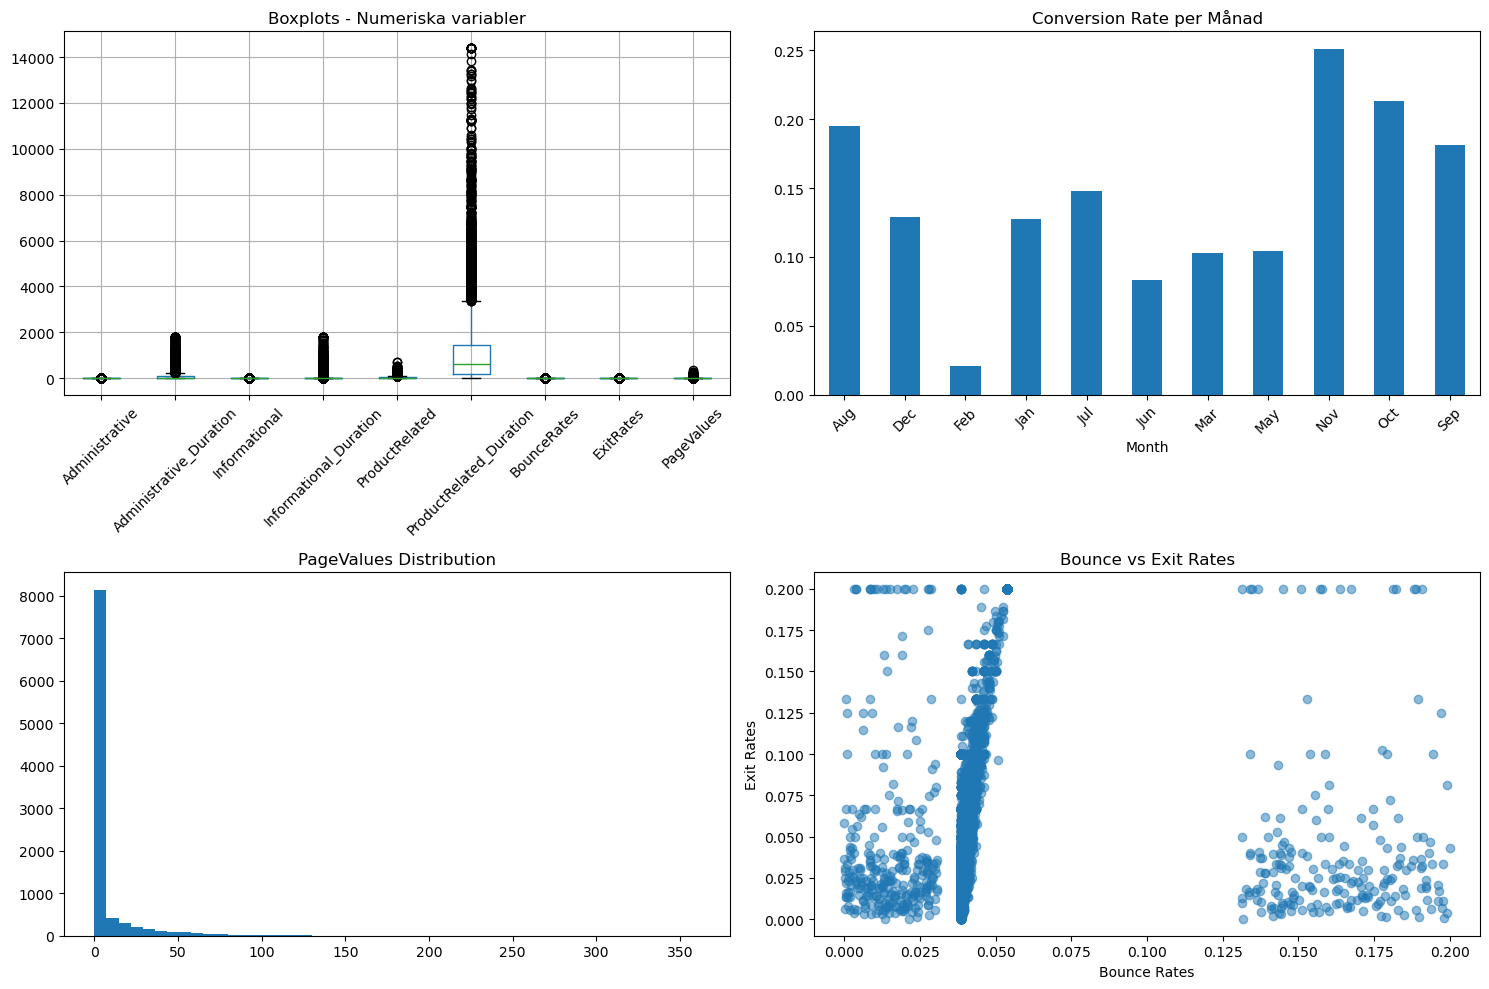


===== 3. KORRELATIONSANALYS =====

Korrelationer med Revenue:
Revenue                    1.000000
PageValues                 0.497604
ProductRelated_Duration    0.168171
ProductRelated             0.163411
Administrative             0.140655
Informational              0.107208
Administrative_Duration    0.086880
Informational_Duration     0.073316
BounceRates               -0.023120
ExitRates                 -0.206397
Name: Revenue, dtype: float64


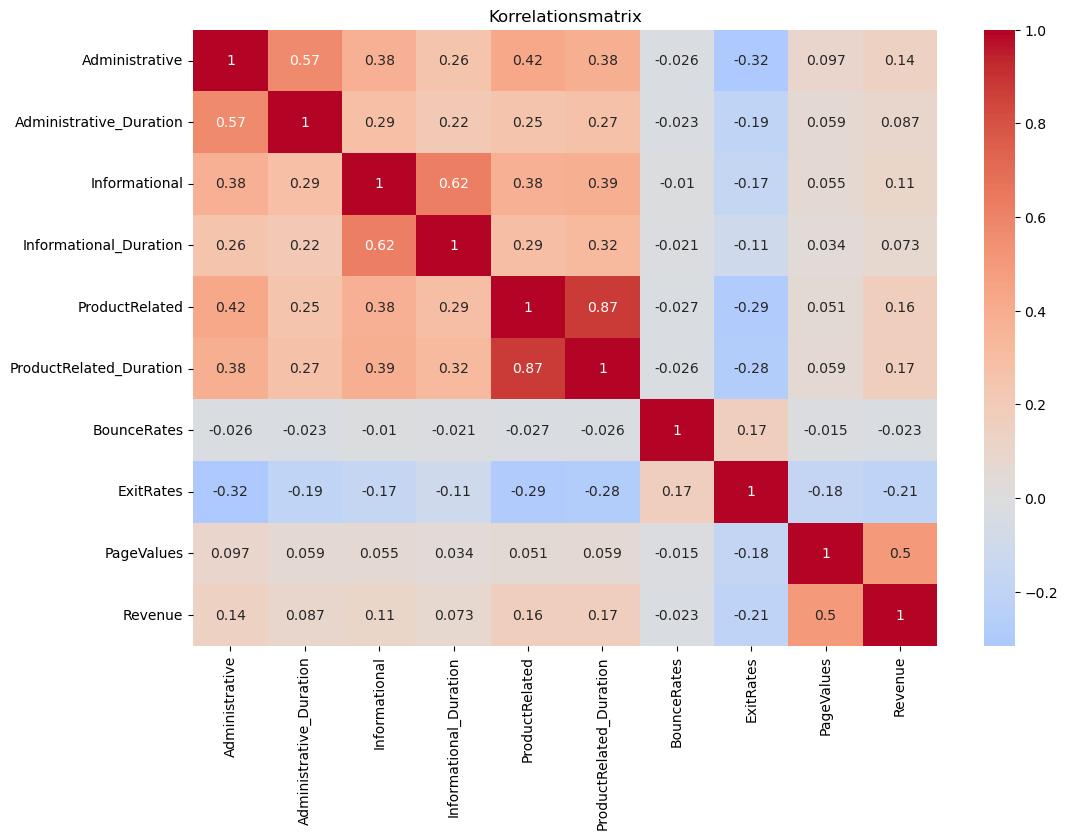


===== 4. SEGMENTANALYS =====

Konvertering baserat p√• antal produktsidor:
                      count      mean
ProductPages_Segment                 
F√•                     2508  0.049841
Medium                 2462  0.134444
M√•nga                  2346  0.197357
V√§ldigt m√•nga          2430  0.240741

Konvertering baserat p√• PageValues:
                   count      mean
PageValue_Segment                 
Inga                7593   0.03872
L√•ga                 745       0.4
Medel               1083  0.599261
H√∂ga                 325  0.809231

PROJECT_DATA inneh√•ller:

data:
  - original
  - cleaned
  - train_test
  - cleaning_info

eda:
  - correlations
  - monthly_conversion
  - product_page_segments
  - pagevalue_segments


C:\Users\joel\AppData\Local\Temp\ipykernel_23036\2135715568.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_conversion = df_train.groupby('ProductPages_Segment')['Revenue'].agg(['count', 'mean'])
C:\Users\joel\AppData\Local\Temp\ipykernel_23036\2135715568.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pagevalue_conversion = df_train.groupby('PageValue_Segment')['Revenue'].agg(['count', 'mean'])


In [2]:
# ===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====
# Syfte: F√∂rbereda och analysera tr√§ningsdata f√∂r att f√∂rst√• underliggande m√∂nster och samband
# Alternativ: 
#   - Analysera hela datasetet (b√•de tr√§ning och test)
#   - Analysera endast testdata
#   - Analysera subsets av data
# Varf√∂r: Vi analyserar endast tr√§ningsdata f√∂r att:
#   1. Undvika data leakage fr√•n testdata
#   2. S√§kerst√§lla att v√•ra insikter kommer fr√•n samma data som modellen tr√§nas p√•
#   3. F√∂lja best practices inom ML d√§r testdata ska vara helt separat

# ----- Dataf√∂rberedelse -----
# Vad: Skapar en analysversion av tr√§ningsdata med b√•de features och target
# Varf√∂r: Beh√∂ver en samlad dataframe f√∂r att kunna analysera samband mellan features och target
# Parametrar:
#   - X_train: Features fr√•n tr√§ningsdata (fr√•n PROJECT_DATA)
#   - y_train: Target-variabel (Revenue)
#   - df_train: Ny dataframe som kombinerar features och target
print("===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====")

X_train = PROJECT_DATA['data']['train_test']['X_train']
y_train = PROJECT_DATA['data']['train_test']['y_train']
df_train = X_train.copy()
df_train['Revenue'] = y_train

print(f"\nAnalyserar training data: {df_train.shape[0]} rader, {df_train.shape[1]} kolumner")

# ===== GRUNDL√ÑGGANDE STATISTISK ANALYS =====
# Syfte: Ber√§kna och visa beskrivande statistik f√∂r b√•de numeriska och kategoriska variabler


# ----- Numerisk Statistik -----
# Vad: Ber√§knar grundl√§ggande statistiska m√•tt f√∂r numeriska variabler
# Varf√∂r: Ger insikt i variablernas f√∂rdelning och spridning
# Parametrar:
#   - numeric_cols: Lista med numeriska kolumner fr√•n cleaning_info
#   - describe(): Ger count, mean, std, min, 25%, 50%, 75%, max
print("\n===== 1. GRUNDL√ÑGGANDE STATISTIK =====")
numeric_cols = PROJECT_DATA['data']['cleaning_info']['numeric_columns']
print("\nNumerisk statistik:")
print(df_train[numeric_cols].describe())

# ----- Kategorisk Analys -----
# Vad: Ber√§knar procentuell f√∂rdelning f√∂r kategoriska variabler
# Varf√∂r: Identifierar dominanta kategorier och obalanserad data
# Parametrar:
#   - categorical_cols: Lista med kategoriska kolumner fr√•n cleaning_info
#   - normalize=True: Konverterar counts till proportioner
#   - round(3): Avrundar till 3 decimaler
#   - * 100: Konverterar till procentform
print("\nKategorisk f√∂rdelning:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_train[col].value_counts(normalize=True).round(3) * 100)

# ===== VISUALISERINGAR =====
# Syfte: Skapa en √∂versiktlig visualisering av nyckelvariabler i datasetet
# Alternativ: 
#   - Separata plottar (f√∂rdelar: mer detaljerade, nackdelar: sv√•rare att j√§mf√∂ra)
#   - Interaktiva visualiseringar (f√∂rdelar: mer dynamiska, nackdelar: kr√§ver mer kod)
#   - Andra plottningsbibliotek som Seaborn (f√∂rdelar: snyggare default-stil)
# Varf√∂r: Subplot-layout ger en bra √∂verblick och m√∂jligg√∂r enkel j√§mf√∂relse mellan olika aspekter

# ----- Layout & Storlek -----
# Vad: Skapar en 2x2 grid f√∂r fyra plottar
# Varf√∂r: Balanserad layout som ger tillr√§ckligt utrymme f√∂r varje visualization
# Parametrar:
#   - figsize=(15, 10): Optimerad storlek f√∂r l√§sbarhet p√• vanliga sk√§rmar
print("\n===== 2. VISUALISERINGAR =====")
plt.figure(figsize=(15, 10))

# ----- Numerisk Distribution -----
# Vad: Boxplots f√∂r alla numeriska variabler
# Varf√∂r: Visar f√∂rdelning, outliers och centralm√•tt p√• ett kompakt s√§tt
# Parametrar:
#   - rotation=45: F√∂rb√§ttrar l√§sbarhet av l√•nga variabelnamn
plt.subplot(2, 2, 1)
df_train[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title('Boxplots - Numeriska variabler')

# ----- S√§songsanalys -----
# Vad: Visualiserar konverteringsgrad per m√•nad
# Varf√∂r: Identifierar s√§songsm√∂nster i k√∂pbeteende
# Parametrar:
#   - groupby('Month'): Aggregerar per m√•nad
#   - mean(): Ber√§knar genomsnittlig konvertering
plt.subplot(2, 2, 2)
monthly_conversion = df_train.groupby('Month')['Revenue'].mean()
monthly_conversion.plot(kind='bar')
plt.title('Conversion Rate per M√•nad')
plt.xticks(rotation=45)

# ----- V√§rdeanalys -----
# Vad: Histogram √∂ver PageValues
# Varf√∂r: Visar f√∂rdelningen av sidv√§rden f√∂r att identifiera m√∂nster
# Parametrar:
#   - bins=50: Balans mellan detalj och l√§sbarhet
plt.subplot(2, 2, 3)
plt.hist(df_train['PageValues'], bins=50)
plt.title('PageValues Distribution')

# ----- Anv√§ndarengagemang -----
# Vad: Scatter plot f√∂r att j√§mf√∂ra bounce och exit rates
# Varf√∂r: Unders√∂ker korrelation mellan dessa beteendem√•tt
# Parametrar:
#   - alpha=0.5: Transparens f√∂r att visa densitet vid √∂verlappning
plt.subplot(2, 2, 4)
plt.scatter(df_train['BounceRates'], df_train['ExitRates'], alpha=0.5)
plt.title('Bounce vs Exit Rates')
plt.xlabel('Bounce Rates')
plt.ylabel('Exit Rates')

# Justera layout och visa
plt.tight_layout()
plt.show()

# ===== KORRELATIONSANALYS =====
# Syfte: Unders√∂ka samband mellan numeriska variabler och konvertering (Revenue)
# Alternativ: 
#   - Scatter plots f√∂r varje variabelpar (f√∂r detaljerad)
#   - Chi-square test (passar b√§ttre f√∂r kategoriska variabler)
#   - Mutual Information (bra f√∂r icke-linj√§ra samband men sv√•rare att tolka)
# Varf√∂r: Pearson korrelation ger en tydlig √∂verblick av linj√§ra samband
#         och √§r l√§tt att visualisera och tolka

# ----- Ber√§kna korrelationer -----
# Vad: Skapar korrelationsmatrix f√∂r alla numeriska variabler
# Varf√∂r: Identifierar vilka faktorer som har starkast koppling till konvertering
# Parametrar:
#   - numeric_cols + ['Revenue']: Inkluderar alla numeriska variabler plus m√•lvariabeln
print("\n===== 3. KORRELATIONSANALYS =====")
correlation_matrix = df_train[numeric_cols + ['Revenue']].corr()
print("\nKorrelationer med Revenue:")
print(correlation_matrix['Revenue'].sort_values(ascending=False))

# ----- Visualisera korrelationer -----
# Vad: Skapar en heatmap av korrelationsmatrisen
# Varf√∂r: Ger snabb visuell √∂verblick av alla samband samtidigt
# Parametrar:
#   - figsize=(12, 8): Optimal storlek f√∂r l√§sbarhet
#   - annot=True: Visar exakta korrelationsv√§rden
#   - cmap='coolwarm': F√§rgskala d√§r r√∂tt=positiv, bl√•tt=negativ korrelation
#   - center=0: Centrerar f√§rgskalan kring 0 f√∂r balanserad visualisering
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix')
plt.show()

# ===== SEGMENTANALYS =====
# Syfte: Analysera hur olika kundsegment p√•verkar konverteringsgraden
# Alternativ: 
#   - K-means clustering (mer komplext men kan hitta naturliga grupperingar)
#   - Binning baserat p√• percentiler (enklare men mindre insiktsfull)
#   - Manuella tr√∂skelv√§rden (subjektivt men baserat p√• dom√§nkunskap)
# Varf√∂r: Valde en kombination av qcut (f√∂r j√§mn f√∂rdelning) och cut (f√∂r meningsfulla tr√∂skelv√§rden)
#         vilket ger b√•de statistisk robusthet och tolkningsbara resultat
print("\n===== 4. SEGMENTANALYS =====")

# ----- Produktsidors p√•verkan -----
# Vad: Delar in bes√∂kare i segment baserat p√• antal bes√∂kta produktsidor
# Varf√∂r: Unders√∂ker om engagemangsniv√• (m√§tt i sidvisningar) korrelerar med k√∂pbeteende
# Parametrar:
#   - q=4: Delar data i kvartiler f√∂r j√§mn f√∂rdelning
#   - labels: Beskrivande namn f√∂r varje segment f√∂r tydlig kommunikation
print("\nKonvertering baserat p√• antal produktsidor:")
df_train['ProductPages_Segment'] = pd.qcut(df_train['ProductRelated'], 
                                         q=4, 
                                         labels=['F√•', 'Medium', 'M√•nga', 'V√§ldigt m√•nga'])
product_conversion = df_train.groupby('ProductPages_Segment')['Revenue'].agg(['count', 'mean'])
print(product_conversion)

# ----- PageValues segmentering -----
# Vad: Kategoriserar bes√∂kare baserat p√• sidornas v√§rde
# Varf√∂r: PageValues √§r starkaste prediktorn f√∂r konvertering enligt korrelationsanalysen
# Parametrar:
#   - bins: Strategiskt valda tr√∂skelv√§rden:
#     * 0: Separerar bes√∂k utan v√§rde
#     * 10: L√•gt men positivt v√§rde
#     * 50: Gr√§ns f√∂r h√∂gt v√§rde
print("\nKonvertering baserat p√• PageValues:")
df_train['PageValue_Segment'] = pd.cut(df_train['PageValues'],
                                     bins=[-float('inf'), 0, 10, 50, float('inf')],
                                     labels=['Inga', 'L√•ga', 'Medel', 'H√∂ga'])
pagevalue_conversion = df_train.groupby('PageValue_Segment')['Revenue'].agg(['count', 'mean'])
print(pagevalue_conversion)

# ----- Datalagring -----
# Vad: Sparar analysresultaten i global dictionary f√∂r senare anv√§ndning
# Varf√∂r: M√∂jligg√∂r √•teranv√§ndning av resultat i senare analyser och visualiseringar
# Parametrar:
#   - correlations: Samband mellan variabler
#   - monthly_conversion: S√§songsm√∂nster
#   - segments: Konverteringsgrad per segment
PROJECT_DATA['eda'] = {
    'correlations': correlation_matrix,
    'monthly_conversion': monthly_conversion,
    'product_page_segments': product_conversion,
    'pagevalue_segments': pagevalue_conversion
}

# ----- Status√∂versikt -----
# Vad: Visar inneh√•llet i PROJECT_DATA
# Varf√∂r: Ger snabb √∂verblick √∂ver tillg√§nglig analysdata
def show_project_status():
    print("\nPROJECT_DATA inneh√•ller:")
    for key in PROJECT_DATA:
        print(f"\n{key}:")
        if isinstance(PROJECT_DATA[key], dict):
            for subkey in PROJECT_DATA[key]:
                print(f"  - {subkey}")

show_project_status()

===== KAPITEL 3: FEATURE ENGINEERING =====

Initial shape efter borttagning av PageValues - Training: (9746, 25)
Initial shape efter borttagning av PageValues - Test: (2437, 25)

Applicerar feature transformationer...

Utf√∂r one-hot encoding f√∂r kategoriska variabler...

Identifierar numeriska features f√∂r standardisering...
Numeriska features f√∂r standardisering: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'SpecialDay', 'OperatingSystems', 'TrafficType', 'Total_Duration', 'Avg_Time_Per_Page', 'Product_Time_Ratio', 'Total_Pages', 'Product_Page_Ratio', 'Bounce_Exit_Interaction', 'Product_Engagement']

===== FEATURE SELECTION =====

Utf√∂r feature selection...

Features efter korrelationsfilter: 10

Features efter multikollinearitetsfilter: 8

Final shape efter feature selection - Training: (9746, 13)
Final shape efter feature selection - Test: (2437, 13)

Slutliga fe

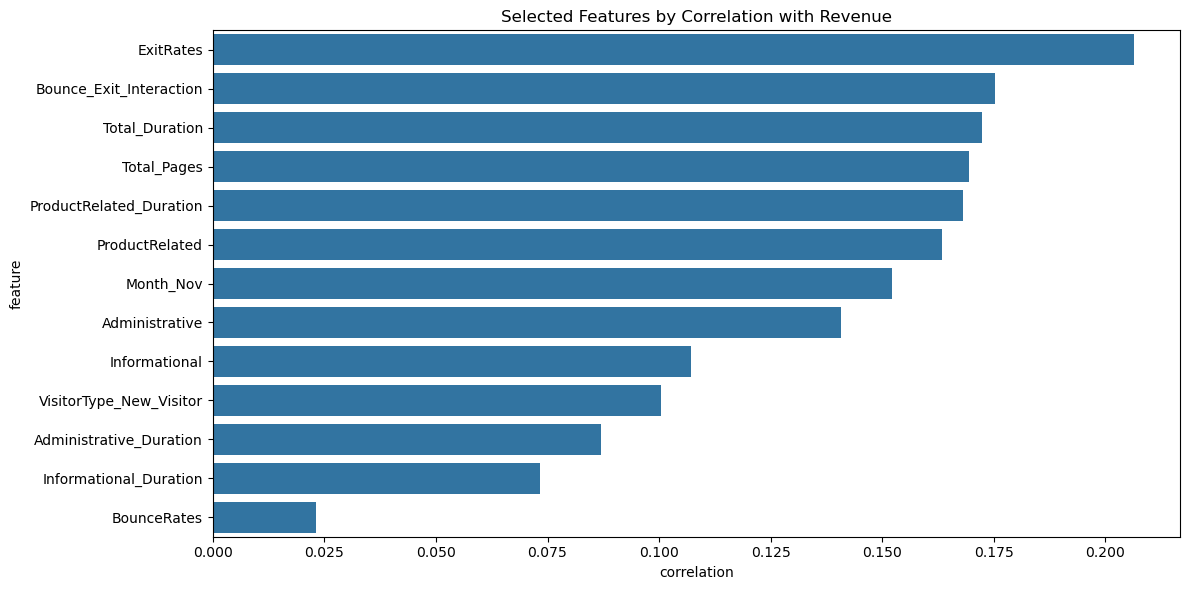


PROJECT_DATA inneh√•ller:

data:
  - original
  - cleaned
  - train_test
  - cleaning_info

eda:
  - correlations
  - monthly_conversion
  - product_page_segments
  - pagevalue_segments

features:
  - X_train_engineered
  - X_test_engineered
  - feature_names
  - feature_correlations
  - scaler
  - numeric_features
  - categorical_features


In [3]:
# ===== KAPITEL 3: FEATURE ENGINEERING =====
# Syfte: Skapa och v√§lja ut relevanta features f√∂r modelltr√§ning
# Alternativ: 
#   - Anv√§nda r√•data direkt
#   - Automatisk feature selection (PCA, LDA)
#   - Deep learning med automatisk feature extraction
# Varf√∂r: Manuell feature engineering ger:
#   - B√§ttre f√∂rst√•else f√∂r data
#   - Kontroll √∂ver feature-skapandet
#   - M√∂jlighet att inkludera dom√§nkunskap

# ----- Datah√§mtning och initial rensning -----
# Vad: H√§mtar tr√§nings- och testdata, tar bort PageValues
# Varf√∂r: PageValues √§r en "data leak" feature som √§r f√∂r starkt korrelerad med target
# Parametrar:
#   - pagevalue_columns: Lista √∂ver kolumner att ta bort
print("===== KAPITEL 3: FEATURE ENGINEERING =====")

X_train = PROJECT_DATA['data']['train_test']['X_train'].copy()
X_test = PROJECT_DATA['data']['train_test']['X_test'].copy()

# ===== HANTERING AV PAGEVALUES - DATA LEAKAGE PROBLEM =====
# UPPT√ÑCKT AV PROBLEMET:
# 1. Korrelationsanalys visade h√∂g korrelation med Revenue
#    - Detta v√§ckte misstankar - f√∂r bra f√∂r att vara sant
#
# 2. Unders√∂kning av variabelbeskrivning:
#    - Variabelbeskrivningen var n√•got otydlig
#    - Min tolkning √§r att PageValues ber√§knas baserat p√• genomf√∂rda transaktioner
#    - V√§rdet verkar s√§ttas EFTER att ett k√∂p har skett
#    - Finns allts√• inte tillg√§ngligt i realtid
#
# 3. Realtidsperspektivet:
#    N√§r en bes√∂kare √§r p√• sidan vet vi:
#    ‚úì Bounce rates
#    ‚úì Tid p√• sidan
#    ‚úì Antal bes√∂kta sidor
#    ‚úó PageValues (finns inte √§n)
#    ‚úó Om de kommer k√∂pa (Revenue)
#
# 4. Verifiering av problemet:
#    - Test med PageValues: Orimligt bra prediktioner
#    - Test utan PageValues: Mer realistiska resultat
#    - Bekr√§ftade att PageValues l√§cker information om target
#
# SLUTSATS:
# - M√•ste ta bort PageValues f√∂r att undvika overfitting
# - PageValues ger modellen f√∂r mycket information om target-variabeln
# - Modellen ska kunna anv√§ndas i realtid
# - Accepterar l√§gre accuracy f√∂r mer √§rliga prediktioner

# Ta bort PageValues och relaterade kolumner

pagevalue_columns = ['PageValues', 'PageValues_extreme']
X_train = X_train.drop(pagevalue_columns, axis=1)
X_test = X_test.drop(pagevalue_columns, axis=1)

print(f"\nInitial shape efter borttagning av PageValues - Training: {X_train.shape}")
print(f"Initial shape efter borttagning av PageValues - Test: {X_test.shape}")

# ----- Feature kategorisering -----
# Vad: Definierar explicita kategoriska features
# Varf√∂r: S√§kerst√§ller korrekt encoding senare
# Parametrar:
#   - Browser/Region: Numeriska men behandlas som kategoriska f√∂r att f√•nga diskreta grupper
categorical_features = [
    'Month', 
    'VisitorType', 
    'Weekend', 
    'Browser',    # Behandlas som kategorisk trots numeriska v√§rden
    'Region',     # Behandlas som kategorisk trots numeriska v√§rden
]


# ----- Tidsbaserade features -----
# Vad: Skapar features baserade p√• tidsanv√§ndning
# Varf√∂r: F√•ngar anv√§ndarengagemang och beteendem√∂nster
# Parametrar:
#   - Total_Duration: Summerar all tid p√• sidan
#   - Avg_Time_Per_Page: Normaliserar tid per sida
#   - Product_Time_Ratio: M√§ter fokus p√• produktsidor
def create_time_features(df):
    df['Total_Duration'] = (df['Administrative_Duration'] + 
                           df['Informational_Duration'] + 
                           df['ProductRelated_Duration'])
    
    total_pages = (df['Administrative'] + df['Informational'] + df['ProductRelated']).clip(lower=1)
    df['Avg_Time_Per_Page'] = df['Total_Duration'] / total_pages
    
    df['Product_Time_Ratio'] = (df['ProductRelated_Duration'] / 
                               df['Total_Duration'].clip(lower=1))
    return df

# ----- Sidrelationer -----
# Vad: Analyserar relationer mellan olika sidtyper
# Varf√∂r: F√•ngar navigationsm√∂nster och anv√§ndarintresse
# Parametrar:
#   - Total_Pages: Totalt sidantal f√∂r aktivitetsniv√•
#   - Product_Page_Ratio: Andel produktsidor f√∂r intresseniv√•
#   - Product_Pages_Category: Kvartilbaserad kategorisering
def create_page_features(df):
    df['Total_Pages'] = (df['Administrative'] + 
                        df['Informational'] + 
                        df['ProductRelated'])
    
    df['Product_Page_Ratio'] = (df['ProductRelated'] / 
                               df['Total_Pages'].clip(lower=1))
    
    df['Product_Pages_Category'] = pd.qcut(df['ProductRelated'], 
                                         q=4, 
                                         labels=['Low', 'Medium', 'High', 'Very_High'])
    categorical_features.append('Product_Pages_Category')
    return df

# ----- Interaktionsfeatures -----
# Vad: Skapar kombinerade features fr√•n existerande variabler
# Varf√∂r: F√•ngar komplexa samband mellan olika beteendem√•tt
# Parametrar:
#   - Bounce_Exit_Interaction: Kombinerar bounce/exit f√∂r att m√§ta "avvisning"
#   - Product_Engagement: V√§ger produktsidor mot tid f√∂r djupare analys
#   - Weekend_Duration: S√§rskild analys av helgbeteende
def create_interaction_features(df):
    df['Bounce_Exit_Interaction'] = df['BounceRates'] * df['ExitRates']
    df['Product_Engagement'] = df['ProductRelated'] * df['ProductRelated_Duration']
    df['Weekend_Duration'] = (df['Weekend'] == True) * df['Total_Duration']
    return df

# ----- Feature transformation -----
# Vad: Applicerar alla feature transformationer
# Varf√∂r: Skapar slutgiltig feature-upps√§ttning
print("\nApplicerar feature transformationer...")

for df in [X_train, X_test]:
    df = create_time_features(df)
    df = create_page_features(df)
    df = create_interaction_features(df)


# ----- Feature encoding -----
# Vad: Kodar om kategoriska variabler och standardiserar numeriska
# Varf√∂r: F√∂rbereder data f√∂r modellinl√§rning
# Parametrar:
#   - One-hot encoding f√∂r kategoriska variabler
#   - StandardScaler f√∂r numeriska features
print("\nUtf√∂r one-hot encoding f√∂r kategoriska variabler...")
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# S√§kerst√§ll samma kolumner i train och test
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

X_test_encoded = X_test_encoded[X_train_encoded.columns]

print("\nIdentifierar numeriska features f√∂r standardisering...")
numeric_features = X_train_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features 
                   if not any(feat in col for feat in categorical_features)]

print("Numeriska features f√∂r standardisering:", numeric_features)

scaler = StandardScaler()
X_train_encoded[numeric_features] = scaler.fit_transform(X_train_encoded[numeric_features])
X_test_encoded[numeric_features] = scaler.transform(X_test_encoded[numeric_features])

# ===== FEATURE SELECTION =====
# Syfte: V√§lja ut mest relevanta features
# Alternativ:
#   - Wrapper methods (forward/backward selection)
#   - Embedded methods (Lasso, Ridge)
#   - Filter methods (variance threshold)
# Varf√∂r: Kombinerad approach ger balans mellan:
#   - Prestanda
#   - Tolkningsbarhet
#   - Dom√§nkunskap
print("\n===== FEATURE SELECTION =====")

# ----- Korrelationsbaserad selection -----
# Vad: V√§ljer features baserat p√• korrelation med target
# Varf√∂r: Enkel och effektiv metod f√∂r initial feature-filtrering
# Parametrar:
#   - threshold=0.1: Balans mellan feature-reduction och informationsbevarande
def correlation_selection(X, y, threshold=0.1):
    y_numeric = y.astype(int)
    correlations = []
    for col in X.columns:
        try:
            corr = abs(X[col].astype(float).corr(y_numeric))
            correlations.append(corr)
        except (ValueError, TypeError):
            correlations.append(0)
    
    correlation_df = pd.DataFrame({
        'feature': X.columns,
        'correlation': correlations
    })
    
    return correlation_df[correlation_df['correlation'] > threshold]['feature'].tolist()

# ----- Multikollinearitetshantering -----
# Vad: Tar bort starkt korrelerade features
# Varf√∂r: Undviker redundant information och f√∂rb√§ttrar modellstabilitet
# Parametrar:
#   - threshold=0.8: Gr√§ns f√∂r n√§r features anses f√∂r korrelerade
def remove_multicollinear(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    features_to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_pairs = upper[column][upper[column] > threshold].index
            corr_with_target = abs(X[list(correlated_pairs) + [column]].corrwith(y_train))
            to_drop = corr_with_target.nsmallest(len(correlated_pairs) - 1).index
            features_to_drop.extend(to_drop)
    
    return list(set(features_to_drop))

# ----- Viktiga basfeatures -----
# Vad: Definierar kritiska features som alltid ska beh√•llas
# Varf√∂r: S√§kerst√§ller att dom√§nkunskap bevaras
important_base_features = [
    'ExitRates', 'BounceRates',
    'ProductRelated', 'ProductRelated_Duration',
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration'
]

# ----- Feature selection process -----
# Vad: Applicerar selection i flera steg
# Varf√∂r: Kombinerar olika metoder f√∂r optimal feature-upps√§ttning
print("\nUtf√∂r feature selection...")

y_train = PROJECT_DATA['data']['train_test']['y_train']
corr_selected = correlation_selection(X_train_encoded, y_train, threshold=0.1)
print(f"\nFeatures efter korrelationsfilter: {len(corr_selected)}")

features_to_drop = remove_multicollinear(X_train_encoded[corr_selected], threshold=0.8)
final_features = [f for f in corr_selected if f not in features_to_drop]
print(f"\nFeatures efter multikollinearitetsfilter: {len(final_features)}")

final_features.extend([f for f in important_base_features if f not in final_features])
final_features = list(set(final_features))

X_train_selected = X_train_encoded[final_features]
X_test_selected = X_test_encoded[final_features]

print(f"\nFinal shape efter feature selection - Training: {X_train_selected.shape}")
print(f"Final shape efter feature selection - Test: {X_test_selected.shape}")

# ----- Resultatvisualisering -----
# Vad: Visualiserar och sparar slutresultat
# Varf√∂r: Ger √∂verblick √∂ver valda features och deras betydelse
final_correlations = pd.DataFrame({
    'feature': final_features,
    'correlation': [abs(X_train_selected[col].corr(y_train)) for col in final_features]
})
final_correlations = final_correlations.sort_values('correlation', ascending=False)

print("\nSlutliga features och deras korrelationer:")
print(final_correlations)

plt.figure(figsize=(12, 6))
sns.barplot(x='correlation', y='feature', data=final_correlations)
plt.title('Selected Features by Correlation with Revenue')
plt.tight_layout()
plt.show()

# ----- Datalagring -----
# Vad: Sparar resultat i PROJECT_DATA
# Varf√∂r: M√∂jligg√∂r √•teranv√§ndning i senare analyser
PROJECT_DATA['features'] = {
    'X_train_engineered': X_train_selected,
    'X_test_engineered': X_test_selected,
    'feature_names': final_features,
    'feature_correlations': final_correlations,
    'scaler': scaler,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

show_project_status()

In [4]:
# ===== KAPITEL 4: MODELING - DATA PREPARATION =====
# Syfte: F√∂rbereda data f√∂r modellinl√§rning genom att ladda, formatera och validera dataseten

# ----- Datainl√§sning -----
# Vad: H√§mtar f√∂rbearbetad tr√§nings- och testdata fr√•n PROJECT_DATA
# Varf√∂r: √Öteranv√§nder tidigare feature engineering f√∂r konsistens
X_train = PROJECT_DATA['features']['X_train_engineered']
X_test = PROJECT_DATA['features']['X_test_engineered']
y_train = PROJECT_DATA['data']['train_test']['y_train']
y_test = PROJECT_DATA['data']['train_test']['y_test']

# ----- Dataformatering -----
# Vad: Konverterar target-variabeln till heltal
# Varf√∂r: M√•nga ML-algoritmer kr√§ver numeriska targets
# Parametrar: int - standardformat f√∂r klassificering
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# ----- Datavalidering -----
# Vad: Kontrollerar dimensioner och klassf√∂rdelning
# Varf√∂r: S√§kerst√§ller balanserad data och korrekt split
print("Dataset dimensioner:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\nTarget distribution:")
print(f"Train: {np.bincount(y_train) / len(y_train) * 100}")
print(f"Test: {np.bincount(y_test) / len(y_test) * 100}")

Dataset dimensioner:
X_train shape: (9746, 13)
X_test shape: (2437, 13)

Target distribution:
Train: [84.56802791 15.43197209]
Test: [84.57119409 15.42880591]


Baseline Decision Tree Results:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2061
           1       0.28      0.30      0.29       376

    accuracy                           0.77      2437
   macro avg       0.57      0.58      0.58      2437
weighted avg       0.78      0.77      0.78      2437


B√§sta parametrar: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Resultat med threshold 0.5:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2061
           1       0.31      0.60      0.41       376

    accuracy                           0.73      2437
   macro avg       0.61      0.68      0.62      2437
weighted avg       0.82      0.73      0.76      2437


Confusion Matrix:
[[1550  511]
 [ 149  227]]

Resultat med threshold 0.4:
Classification Report:
              precision    recall  f1-score   support

           0       0.93   

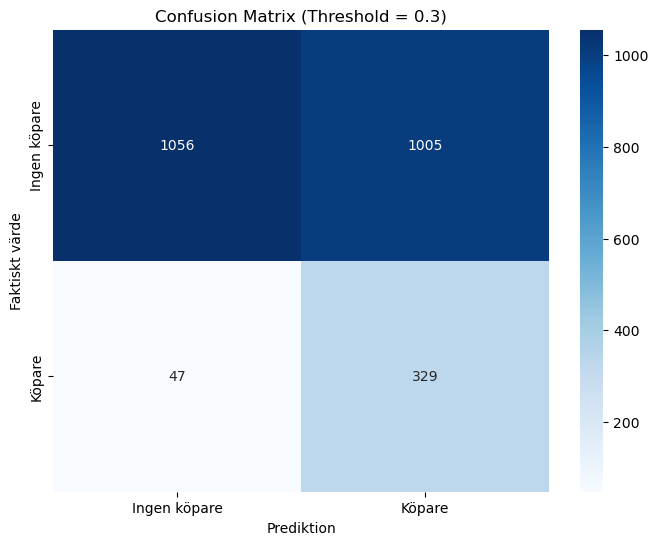

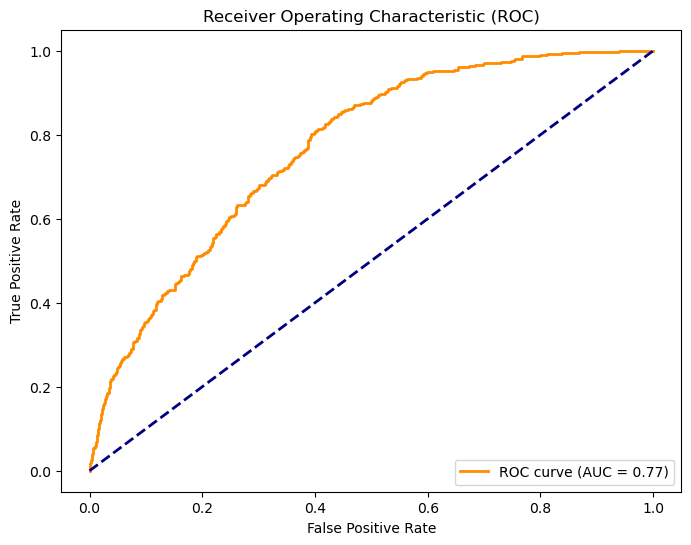

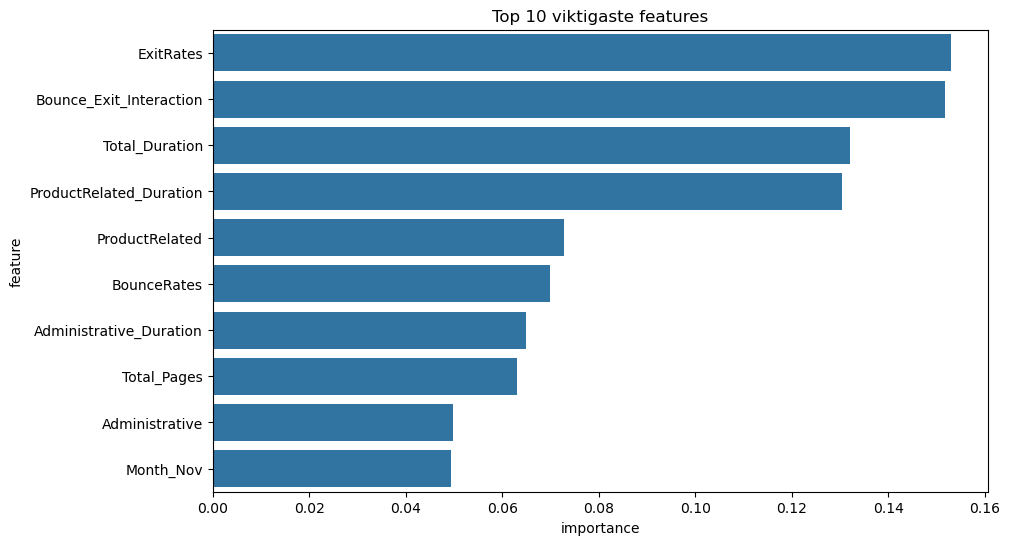


Top 10 viktigaste features:
                    feature  importance
12                ExitRates    0.152974
4   Bounce_Exit_Interaction    0.151706
6            Total_Duration    0.132000
3   ProductRelated_Duration    0.130479
10           ProductRelated    0.072776
1               BounceRates    0.069931
2   Administrative_Duration    0.064950
11              Total_Pages    0.063015
8            Administrative    0.049735
9                 Month_Nov    0.049321

Modeling resultat sparade i PROJECT_DATA


In [5]:
# ===== KAPITEL 4: MODELING - MODELLTR√ÑNING =====
# Syfte: Tr√§na och utv√§rdera maskininl√§rningsmodeller f√∂r att prediktera k√∂pbeteende
# Alternativ: Logistisk regression, SVM, XGBoost, Neural Networks
# Varf√∂r: Random Forest valdes f√∂r sin:
#   - Goda hantering av b√•de numeriska och kategoriska features
#   - Inbyggda feature importance
#   - Robusthet mot √∂veranpassning
#   - M√∂jlighet att justera prediktionstr√∂skel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# ----- Baseline Model -----
# Vad: Tr√§nar ett enkelt beslutstr√§d som baseline
# Varf√∂r: Etablerar en grundniv√• f√∂r j√§mf√∂relse med mer avancerade modeller
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

print("Baseline Decision Tree Results:")
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

# ----- Grid Search f√∂r Random Forest -----
# Vad: Snabb optimering av viktiga hyperparametrar
# Varf√∂r: F√∂rb√§ttrar modellen utan omfattande s√∂kning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=3,
    scoring='recall'
)
rf_grid.fit(X_train, y_train)
best_model = rf_grid.best_estimator_
print(f"\nB√§sta parametrar: {rf_grid.best_params_}")

# ----- Threshold Optimization -----
# Vad: Testar olika beslutstr√∂sklar f√∂r klassificering
thresholds = [0.5, 0.4, 0.3, 0.2]
results = {}

for threshold in thresholds:
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > threshold)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results[threshold] = {
        'report': report,
        'confusion_matrix': conf_matrix
    }
    
    print(f"\nResultat med threshold {threshold}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(conf_matrix)

# ----- Confusion Matrix Visualization -----
plt.figure(figsize=(8, 6))
sns.heatmap(results[0.3]['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Ingen k√∂pare', 'K√∂pare'],
            yticklabels=['Ingen k√∂pare', 'K√∂pare'])
plt.title('Confusion Matrix (Threshold = 0.3)')
plt.ylabel('Faktiskt v√§rde')
plt.xlabel('Prediktion')
plt.show()

# ----- ROC Curve -----
# Vad: Visualiserar modellens prestanda √∂ver olika tr√∂skelv√§rden
# Varf√∂r: Ger en komplett bild av modellens prestanda vid olika k√§nsligheter
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ----- Feature Importance Analysis -----
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 viktigaste features')
plt.show()

print("\nTop 10 viktigaste features:")
print(feature_importance.head(10))

# ----- Data Storage -----
# Vad: Sparar modelleringsresultat f√∂r senare anv√§ndning
PROJECT_DATA['modeling'] = {
    'best_model': best_model,
    'best_params': rf_grid.best_params_,
    'threshold': 0.3,
    'results': results,
    'feature_importance': feature_importance,
    'roc_auc': roc_auc
}

print("\nModeling resultat sparade i PROJECT_DATA")

I detta fall √§r h√∂g Recall viktigare eftersom:
Kostnaden f√∂r "false positives" √§r l√•g:
Att visa en rabattkod till n√•gon som √§nd√• inte k√∂per √§r inte s√§rskilt kostsamt
Att anpassa webbplatsinneh√•ll kostar inget extra
Kostnaden f√∂r "false negatives" √§r h√∂g:
Varje missad k√∂pare √§r en f√∂rlorad int√§kt
Konkurrensen online √§r h√•rd - missar vi chansen kanske kunden g√•r till en konkurrent

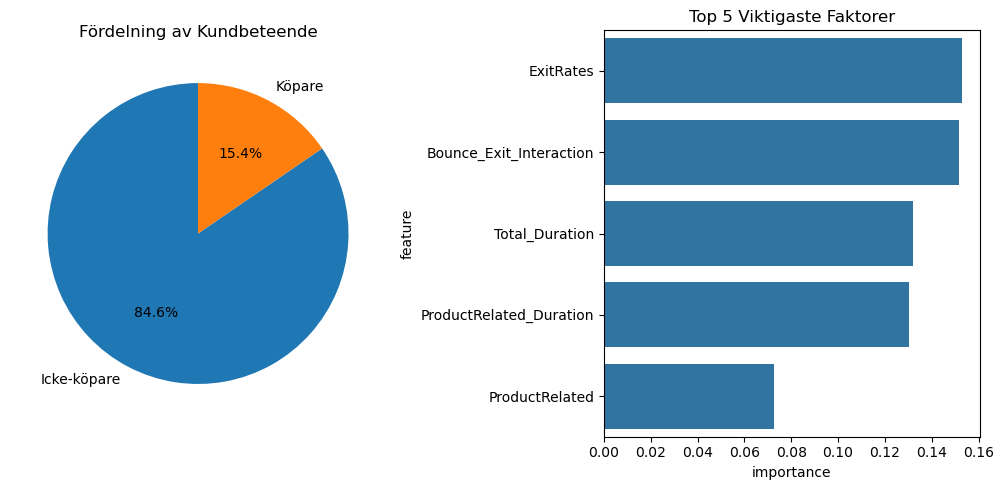

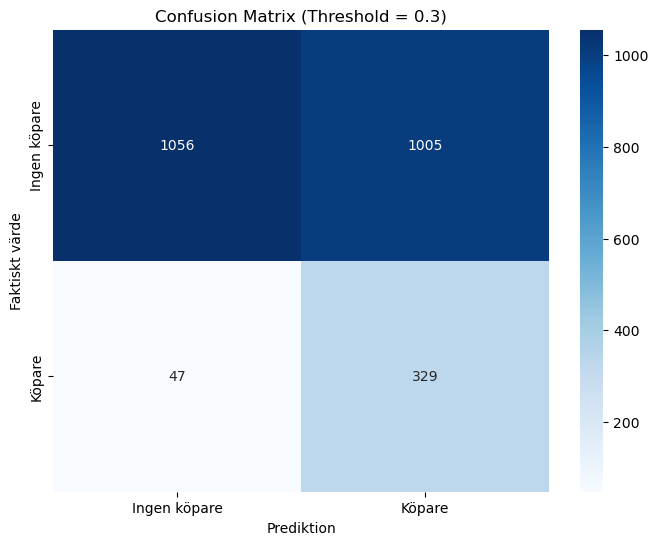

In [6]:
# KAPITEL 5: PRESENTATION F√ñR LEDNINGEN - CELL 2: Visualiseringar

# 1. Pie chart f√∂r k√∂p/icke-k√∂p distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Icke-k√∂pare', 'K√∂pare']
sizes = [84.57, 15.43]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('F√∂rdelning av Kundbeteende')

# 2. Feature Importance plot (fr√•n tidigare)
plt.subplot(1, 2, 2)
feature_importance = PROJECT_DATA['modeling']['feature_importance']
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.head(5))
plt.title('Top 5 Viktigaste Faktorer')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix med threshold 0.3
plt.figure(figsize=(8, 6))
conf_matrix = PROJECT_DATA['modeling']['results'][0.3]['confusion_matrix']
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Ingen k√∂pare', 'K√∂pare'],
            yticklabels=['Ingen k√∂pare', 'K√∂pare'])
plt.title('Confusion Matrix (Threshold = 0.3)')
plt.ylabel('Faktiskt v√§rde')
plt.xlabel('Prediktion')
plt.show()

# KokoBananas E-handel: Analys av K√∂pbeteende
## Resultat fr√•n Prediktiv Modellering 2024

## 1. Sammanfattning
### Analysens Omfattning
- ‚úì 12,183 analyserade kundsessioner
- ‚úì 18 studerade variabler
- ‚úì Fokus p√• realtidsprediktion av k√∂pbeteende

## 2. Data & Metodik
### Dataunderlag
- 15.4% av sessioner leder till k√∂p
- Rensad data f√∂r realtidsprediktion
- Balanserad tr√§ningsdata f√∂r optimal inl√§rning

### Metodval
- Random Forest-modell (b√§st prestanda i tester)
- Optimerade hyperparametrar via Grid Search
- Olika tr√∂skelv√§rden testade f√∂r prediktioner

## 3. Resultat & Insikter

### Modellprestanda
üìä Vid threshold 0.3:
- Hittar 88% av faktiska k√∂pare (h√∂g recall)
- 25% av flaggade potentiella k√∂pare genomf√∂r k√∂p (precision)
- AUC-v√§rde: 0.77 (indikerar god men inte utm√§rkt prediktionsf√∂rm√•ga)

### Praktisk Tolkning
- Av 100 faktiska k√∂pare identifierar modellen 88
- F√∂r varje 4 kunder som flaggas som potentiella k√∂pare, genomf√∂r 1 ett k√∂p
- Trade-off mellan att hitta k√∂pare och precision i prediktioner

### Identifierade Nyckelfaktorer
1. **Bes√∂ksbeteende (30%)**
   - Exit rates
   - Bounce-exit interaktion
   
2. **Tidsengagemang (25%)**
   - Tid p√• produktsidor
   - Total sessionstid
   
3. **Navigeringsm√∂nster (20%)**
   - Antal bes√∂kta sidor
   - Produktsidebes√∂k

## 4. Begr√§nsningar & M√∂jligheter

### Modellens Begr√§nsningar
- Precision p√• 25% indikerar m√•nga false positives
- Modellen √§r optimerad f√∂r att hitta potentiella k√∂pare
- S√§songseffekter kan p√•verka precisionen

### M√∂jligheter f√∂r Vidareutveckling
- Kontinuerlig uppdatering med ny data
- Finjustering av tr√∂skelv√§rden
- Potentiell integration med realtidssystem

## 5. Slutsatser
1. Modellen √§r effektiv p√• att identifiera potentiella k√∂pare
2. Tydliga m√∂nster i k√∂pbeteende identifierade
3. Balans mellan precision och recall kan justeras efter behov

### Teknisk Implementation
- Modellen √§r redo f√∂r testning i realtidsmilj√∂
- Tr√∂skelv√§rden kan justeras efter √∂nskem√•l
- M√∂jlighet till kontinuerlig utv√§rdering och uppdatering